作业任务：

1. 初始化参数：
    1.1：使用0来初始化参数。
    1.2：使用随机数来初始化参数。
    1.3：使用抑梯度异常初始化参数（参见视频中的梯度消失和梯度爆炸）。
2. 正则化模型：
    2.1：使用二范数对二分类模型正则化，尝试避免过拟合。
    2.2：使用随机删除节点的方法精简模型，同样是为了尝试避免过拟合。
3. 梯度校验  ：对模型使用梯度校验，检测它是否在梯度下降的过程中出现误差过大的情况。

In [10]:
# 导入相关文件
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import init_utils  #初始化部分
import reg_utils  #正则化部分
import gc_utils  #梯度校验

plt.rcParams['figure.figsize'] = (7.0, 4.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=np.squeeze(y), cmap=plt.cm.Spectral) #更改这里的y
    plt.show()

In [11]:
train_X, train_Y, test_X, test_Y = init_utils.load_dataset(is_plot=True)

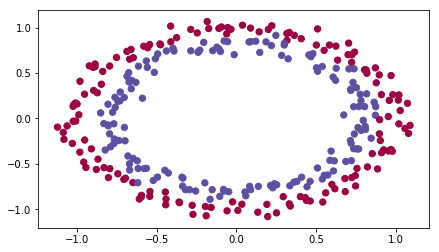

In [12]:
plt.show()

我们将要建立一个分类器把蓝点和红点分开，在之前我们已经实现过一个3层的神经网络，我们将对它进行初始化：

我们将会尝试下面三种初始化方法:

  1、初始化为0：在输入参数中全部初始化为0，参数名为initialization = “zeros”，核心代码： 
     parameters['W' + str(l)] = np.zeros((layers_dims[l], layers_dims[l - 1]))

  2、初始化为随机数：把输入参数设置为随机值，权重初始化为大的随机值。参数名为initialization = “random”，核心代码： 
  parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l - 1]) * 10

   3、抑梯度异常初始化：参见梯度消失和梯度爆炸的那一个视频，参数名为initialization = “he”，核心代码： 
  parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l - 1]) * np.sqrt(2 / layers_dims[l - 1])


In [13]:
# 定义模型
def model(X, Y, learning_rate = 0.01, num_iterations = 15000, print_cost = True, 
          initialization = "he", is_plot = True):
#     """
#         实现一个三层的神经网络：LINEAR ->RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID

#     参数：
#         X - 输入的数据，维度为(2, 要训练/测试的数量)
#         Y - 标签，【0 | 1】，维度为(1，对应的是输入的数据的标签)
#         learning_rate - 学习速率
#         num_iterations - 迭代的次数
#         print_cost - 是否打印成本值，每迭代1000次打印一次
#         initialization - 字符串类型，初始化的类型【"zeros" | "random" | "he"】
#         is_polt - 是否绘制梯度下降的曲线图
#     返回
#         parameters - 学习后的参数

#     """
    grads = {}
    costs = []
    m = X.shape[1]
    layers_dims = [X.shape[0], 10, 5, 1]
    
    #选择初始化方法
    if initialization == "zeros":
        parameters = initialize_parameters_zeros(layers_dims)
    elif initialization == "random":
        parameters = initialize_parameters_random(layers_dims)
    elif initialization == "he":
        parameters = initialize_parameters_he(layers_dims)
    else:
        print("错误的初始化参数！程序退出")
        exit

    #开始学习
    for i in range(0, num_iterations):
        #forward propagate
        a3, cache = init_utils.forward_propagation(X, parameters)
        
        # cost function
        cost = init_utils.compute_loss(a3, Y)
        
        # backward propagate
        grads = init_utils.backward_propagation(X, Y, cache)
        
        # update parameters
        parameters = init_utils.update_parameters(parameters, grads, learning_rate)
        
        # recording cost
        if i % 1000 == 0:
            costs.append(cost)
            # print cost
            if print_cost:
                print("第" + str(i) + "次迭代， 成本值为：" + str(cost))
    if is_plot:
        plt.plot(costs)
        plt.ylabel('cost')
        plt.xlabel('iterations(per hundreds)')
        plt.title("Learning rate = " + str(learning_rate))
        plt.show()
    
    return parameters

有三种初始化方法：
    1、初始化为零
    2、随机初始化
    3、抑制梯度异常初始化

In [14]:
# 初始化为零
def initialize_parameters_zeros(layers_dims):
#     """
#     将模型的参数全部设置为0

#     参数：
#         layers_dims - 列表，模型的层数和对应每一层的节点的数量
#     返回
#         parameters - 包含了所有W和b的字典
#             W1 - 权重矩阵，维度为（layers_dims[1], layers_dims[0]）
#             b1 - 偏置向量，维度为（layers_dims[1],1）
#             ···
#             WL - 权重矩阵，维度为（layers_dims[L], layers_dims[L -1]）
#             bL - 偏置向量，维度为（layers_dims[L],1）
#     """
    parameters = {}
    L = len(layers_dims)  # 网络层数
    for l in range(1, L):
        parameters["W" + str(l)] = np.zeros((layers_dims[l], layers_dims[l - 1]))
        parameters["b" + str(l)] = np.zeros((layers_dims[l], 1))
    return parameters


In [15]:
# 测试用例
parameters = initialize_parameters_zeros([3, 2, 1])
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[0. 0. 0.]
 [0. 0. 0.]]
b1 = [[0.]
 [0.]]
W2 = [[0. 0.]]
b2 = [[0.]]


第0次迭代， 成本值为：0.6931471805599453
第1000次迭代， 成本值为：0.6931471805599453
第2000次迭代， 成本值为：0.6931471805599453
第3000次迭代， 成本值为：0.6931471805599453
第4000次迭代， 成本值为：0.6931471805599453
第5000次迭代， 成本值为：0.6931471805599453
第6000次迭代， 成本值为：0.6931471805599453
第7000次迭代， 成本值为：0.6931471805599453
第8000次迭代， 成本值为：0.6931471805599453
第9000次迭代， 成本值为：0.6931471805599453
第10000次迭代， 成本值为：0.6931471805599455
第11000次迭代， 成本值为：0.6931471805599453
第12000次迭代， 成本值为：0.6931471805599453
第13000次迭代， 成本值为：0.6931471805599453
第14000次迭代， 成本值为：0.6931471805599453


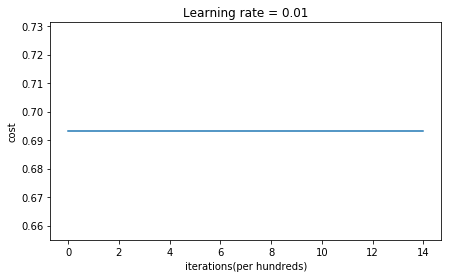

In [16]:
parameters = model(train_X, train_Y, initialization = "zeros",is_plot=True)

In [17]:
print ("训练集:")
predictions_train = init_utils.predict(train_X, train_Y, parameters)
print ("测试集:")
predictions_test = init_utils.predict(test_X, test_Y, parameters)


训练集:
Accuracy: 0.5
测试集:
Accuracy: 0.5


predictions_train = [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0]]
predictions_test = [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


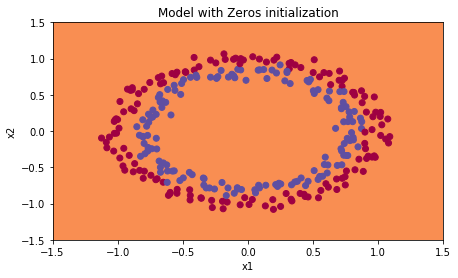

In [18]:
print("predictions_train = " + str(predictions_train))
print("predictions_test = " + str(predictions_test))

plt.title("Model with Zeros initialization")
axes = plt.gca()
axes.set_xlim([-1.5, 1.5])
axes.set_ylim([-1.5, 1.5])
plot_decision_boundary(lambda x: init_utils.predict_dec(parameters, x.T), train_X, train_Y)


In [19]:
# 随机初始化:可以打破对称性
def initialize_parameters_random(layers_dims):
    
#      """
#     参数：
#         layers_dims - 列表，模型的层数和对应每一层的节点的数量
#     返回
#         parameters - 包含了所有W和b的字典
#             W1 - 权重矩阵，维度为（layers_dims[1], layers_dims[0]）
#             b1 - 偏置向量，维度为（layers_dims[1],1）
#             ···
#             WL - 权重矩阵，维度为（layers_dims[L], layers_dims[L -1]）
#             b1 - 偏置向量，维度为（layers_dims[L],1）
#     """
    np.random.seed(3)    
    parameters = {}
    L = len(layers_dims)
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layers_dims[l],
                                            layers_dims[l - 1]) * 10
        parameters['b' + str(l)] = np.zeros((layers_dims[l], 1))
        
    return parameters


In [20]:
# 测试用例
parameters = initialize_parameters_random([3, 2, 1])
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[ 17.88628473   4.36509851   0.96497468]
 [-18.63492703  -2.77388203  -3.54758979]]
b1 = [[0.]
 [0.]]
W2 = [[-0.82741481 -6.27000677]]
b2 = [[0.]]


/Users/paulzyh/AndrewNg 编程作业/第二课/第一周/init_utils.py:50: RuntimeWarning: divide by zero encountered in log
  logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)
/Users/paulzyh/AndrewNg 编程作业/第二课/第一周/init_utils.py:50: RuntimeWarning: invalid value encountered in multiply
  logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)


第0次迭代， 成本值为：inf
第1000次迭代， 成本值为：0.6250676215287511
第2000次迭代， 成本值为：0.5981418252875961
第3000次迭代， 成本值为：0.563858109377261
第4000次迭代， 成本值为：0.5501823050061752
第5000次迭代， 成本值为：0.5444756668990652
第6000次迭代， 成本值为：0.5374638179631746
第7000次迭代， 成本值为：0.4770885368883873
第8000次迭代， 成本值为：0.397834663330821
第9000次迭代， 成本值为：0.3934832163377203
第10000次迭代， 成本值为：0.39203323866307854
第11000次迭代， 成本值为：0.3892818629893498
第12000次迭代， 成本值为：0.3861521882410713
第13000次迭代， 成本值为：0.38499297516135134
第14000次迭代， 成本值为：0.38280470097181446


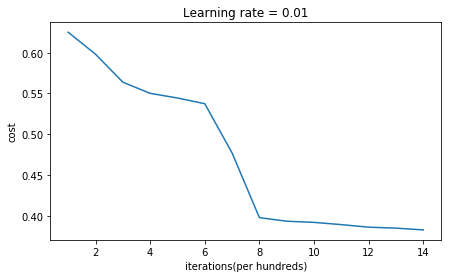

测试集：
Accuracy: 0.83
训练集：
Accuracy: 0.86
[[1 0 1 1 0 0 1 1 1 1 1 0 1 0 0 1 0 1 1 0 0 0 1 0 1 1 1 1 1 1 0 1 1 0 0 1
  1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 1 1 1 0 0 1 1 1 1 0 1 1 0 1 0 1 1 1 1 0
  0 0 0 0 1 0 1 0 1 1 1 0 0 1 1 1 1 1 1 0 0 1 1 1 0 1 1 0 1 0 1 1 0 1 1 0
  1 0 1 1 0 0 1 0 0 1 1 0 1 1 1 0 1 0 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1 0
  0 0 1 0 1 0 1 0 1 1 1 0 0 1 1 1 1 0 1 1 0 1 0 1 1 0 1 0 1 1 1 1 0 1 1 1
  1 0 1 0 1 0 1 1 1 1 0 1 1 0 1 1 0 1 1 0 1 0 1 1 1 0 1 1 1 0 1 0 1 0 0 1
  0 1 1 0 1 1 0 1 1 0 1 1 1 0 1 1 1 1 0 1 0 0 1 1 0 1 1 1 0 0 0 1 1 0 1 1
  1 1 0 1 1 0 1 1 1 0 0 1 0 0 0 1 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 1 1 1
  1 1 1 1 0 0 0 1 1 1 1 0]]
[[1 1 1 1 0 1 0 1 1 0 1 1 1 0 0 0 0 1 0 1 0 0 1 0 1 0 1 1 1 1 1 0 0 0 0 1
  0 1 1 0 0 1 1 1 1 1 0 1 1 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 0
  1 1 1 1 1 0 1 0 0 1 0 0 0 1 1 0 1 1 0 0 0 1 1 0 1 1 0 0]]


In [21]:
parameters = model(train_X, train_Y, initialization = "random", is_plot = True)
print("测试集：")
predictions_train = init_utils.predict(train_X, train_Y, parameters)
print("训练集：")
predictions_test = init_utils.predict(test_X, test_Y, parameters)

print(predictions_train)
print(predictions_test)

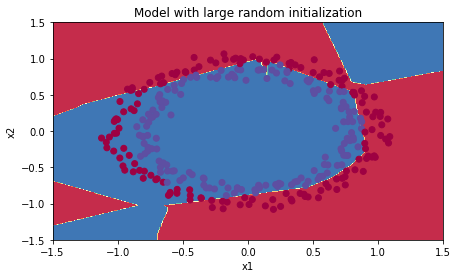

In [22]:
# 绘制图片，分析结果
plt.title("Model with large random initialization")
axes = plt.gca()
axes.set_xlim([-1.5, 1.5])
axes.set_ylim([-1.5, 1.5])
plot_decision_boundary(lambda x : init_utils.predict_dec(parameters, x.T), train_X, train_Y)


In [23]:
# 抑制梯度异常初始化
def initialize_parameters_he(layers_dims):
#     """
#     参数：
#         layers_dims - 列表，模型的层数和对应每一层的节点的数量
#     返回
#         parameters - 包含了所有W和b的字典
#             W1 - 权重矩阵，维度为（layers_dims[1], layers_dims[0]）
#             b1 - 偏置向量，维度为（layers_dims[1],1）
#             ···
#             WL - 权重矩阵，维度为（layers_dims[L], layers_dims[L -1]）
#             b1 - 偏置向量，维度为（layers_dims[L],1）
#     """
    np.random.seed(3)
    parameters = {}
    L = len(layers_dims)
    
    for l in range(1, L):
        parameters["W" + str(l)] = np.random.rand(layers_dims[l], layers_dims[l - 1]) * np.sqrt(2 / layers_dims[l - 1])
        parameters["b" + str(l)] = np.zeros((layers_dims[l], 1))
    return parameters


In [24]:
parameters = initialize_parameters_he([2, 4, 1])
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[0.5507979  0.70814782]
 [0.29090474 0.51082761]
 [0.89294695 0.89629309]
 [0.12558531 0.20724288]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[0.03639281 0.31169963 0.02112567 0.32302987]]
b2 = [[0.]]


第0次迭代， 成本值为：0.887908957520874
第1000次迭代， 成本值为：0.695808546730969
第2000次迭代， 成本值为：0.6900653811094448
第3000次迭代， 成本值为：0.6880416937013079
第4000次迭代， 成本值为：0.6866853022907973
第5000次迭代， 成本值为：0.6852041501540425
第6000次迭代， 成本值为：0.6832577557758225
第7000次迭代， 成本值为：0.6808681767038213
第8000次迭代， 成本值为：0.677552053135525
第9000次迭代， 成本值为：0.6741040320490604
第10000次迭代， 成本值为：0.6694037174950883
第11000次迭代， 成本值为：0.662999988435592
第12000次迭代， 成本值为：0.6547569603824823
第13000次迭代， 成本值为：0.6419990266918241
第14000次迭代， 成本值为：0.6247104389292194


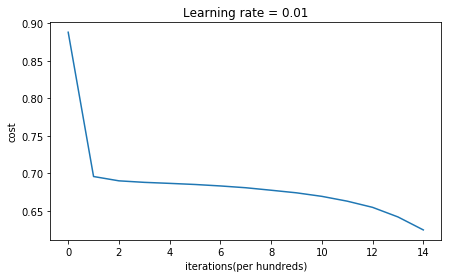

训练集:
Accuracy: 0.69
测试集:
Accuracy: 0.7


In [25]:
parameters = model(train_X, train_Y, initialization = "he",is_plot=True)
print("训练集:")
predictions_train = init_utils.predict(train_X, train_Y, parameters)
print("测试集:")
init_utils.predictions_test = init_utils.predict(test_X, test_Y, parameters)


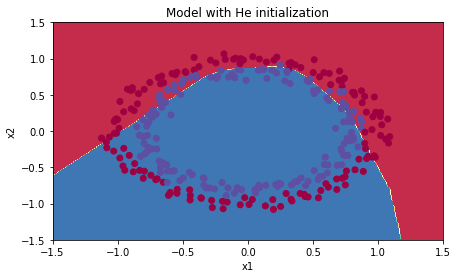

In [26]:
plt.title("Model with He initialization")
axes = plt.gca()
axes.set_xlim([-1.5, 1.5])
axes.set_ylim([-1.5, 1.5])
plot_decision_boundary(lambda x: init_utils.predict_dec(parameters, x.T), train_X, train_Y)